# California housing regression

In this notebook we'll use the ``ITEA_regressor`` to search for a good expression, that will be encapsulated inside the  ``ITExpr_regressor`` class, and it will be used for the regression task of predicting california housing prices.

In [1]:
import numpy  as np
import pandas as pd

from sklearn import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.regression import ITEA_regressor
from itea.inspection import *

import warnings; warnings.filterwarnings('ignore')

The California Housing data set contains 8 features.

In this notebook, we'll provide the transformations functions and its derivatives, instead of using the itea feature of extracting the derivatives using jax.

In [2]:
housing_data = datasets.fetch_california_housing() 
X, y         = housing_data['data'], housing_data['target']
labels       = housing_data['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

tfuncs = {
    'log'      : np.log,
    'sqrt.abs' : lambda x: np.sqrt(np.abs(x)), 
    'id'       : lambda x: x,
    'sin'      : np.sin,
    'cos'      : np.cos,
    'exp'      : np.exp
}

tfuncs_dx = {
    'log'      : lambda x: 1/x,
    'sqrt.abs' : lambda x: x/( 2*(np.abs(x)**(3/2)) ),
    'id'       : lambda x: np.ones_like(x),
    'sin'      : np.cos,
    'cos'      : lambda x: -np.sin(x),
    'exp'      : np.exp,
}

reg = ITEA_regressor(
    gens         = 50,
    popsize      = 50,
    max_terms    = 5,
    expolim      = (-2, 2),
    verbose      = 10,
    tfuncs       = tfuncs,
    tfuncs_dx    = tfuncs_dx,
    labels       = labels,
    random_state = 42,
    simplify_method = 'simplify_by_var'
).fit(X, y)

gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.8262621327388944 	 1.1159122831826924 	 1.153923613058111 	 1min40seg
10 	 0.804700559967339 	 0.8463977749705149 	 0.9020893690442627 	 3min11seg
20 	 0.7795362093991466 	 0.7941148504337509 	 0.8738719900021644 	 2min17seg
30 	 0.7733398229329143 	 0.7893570197862658 	 0.8628567737570586 	 1min33seg
40 	 0.7347068293819388 	 0.7563216163171014 	 0.8177084431749616 	 0min52seg


Now that we have fitted the ITEA, our ``reg`` contains the ``bestsol_`` attribute, which is an fitted instance of ``ITExpr_regressor`` ready to be used. Lets see the final expression and the execution time.

In [3]:
final_itexpr = reg.bestsol_

print('\nFinal expression:\n', final_itexpr.to_str(term_separator=' +\n'))
print(f'\nElapsed time: {reg.exectime_}')


Final expression:
 0.512*log(MedInc^2 * HouseAge^2 * AveRooms^-2 * AveBedrms * AveOccup^2 * Latitude^2 * Longitude^-2) +
-16.002*log(MedInc * HouseAge^-2 * AveRooms^2 * AveBedrms^-1 * AveOccup * Latitude^2 * Longitude^-2) +
16.864*log(MedInc^2 * HouseAge^-2 * AveRooms^2 * AveBedrms^-2 * AveOccup^2 * Latitude^2) +
-0.855*log(MedInc^-2 * HouseAge^-1 * AveRooms^2 * AveOccup * Latitude^-1 * Longitude^-2) +
-9.33*log(MedInc^2 * AveBedrms^-2 * AveOccup^2 * Latitude^2 * Longitude^-2) +
-190.172

Elapsed time: 246.43351793289185


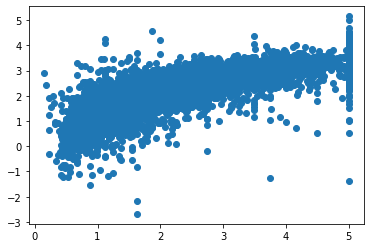

In [4]:
fig, axs = plt.subplots()

axs.scatter(y_test, final_itexpr.predict(X_test))
plt.show()

We can use the ``ITExpr_inspector`` to see informations for each term.

In [5]:
display(pd.DataFrame(
    ITExpr_inspector(
        itexpr=final_itexpr, tfuncs=tfuncs
    ).fit(X_train, y_train).terms_analysis()
))

,coef,func,strengths,coef stderr.,mean pairwise disentanglement,mean mutual information,prediction var.
0,0.512,log,"[2, 2, -2, 1, 0, 2, 2, -2]",0.016,0.240,0.297,0.507
1,-16.002,log,"[1, -2, 2, -1, 0, 1, 2, -2]",0.306,0.372,0.605,650.461
2,16.864,log,"[2, -2, 2, -2, 0, 2, 2, 0]",0.308,0.380,0.633,1100.265
3,-0.855,log,"[-2, -1, 2, 0, 0, 1, -1, -2]",0.009,0.190,0.278,0.733
4,-9.33,log,"[2, 0, 0, -2, 0, 2, 2, -2]",0.159,0.308,0.363,119.373
5,-190.172,intercept,---,3.293,0.000,0.000,0.000


By using the ``ITExpr_texifier``, we can create formatted LaTeX strings of the final expression and its derivatives.

In [6]:
# The final expression
display(Latex(
    '$ ITExpr = ' + ITExpr_texifier.to_latex(
        final_itexpr,
        term_wrapper=lambda i, term: r'\underbrace{' + term + r'}_{\text{term ' + str(i) + '}}'
    ) + '$'
))

<IPython.core.display.Latex object>

In [7]:
# List containing the partial derivatives
derivatives_latex = ITExpr_texifier.derivatives_to_latex(
    final_itexpr,
    term_wrapper=lambda i, term: r'\underbrace{' + term + r'}_{\text{term ' + str(i) + r' partial derivative}}'
)

# displaying one of its derivatives
display(Latex(
    r'$ \frac{\partial}{\partial ' + labels[0] + '} ITExpr = ' + derivatives_latex[0] + '$'
))

<IPython.core.display.Latex object>

We can obtain feature importances using the Partial Effects and the ``ITExpr_explainer``.

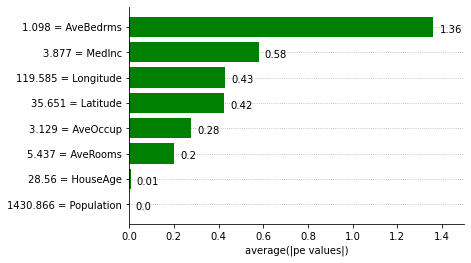

In [8]:
explainer = ITExpr_explainer(
    itexpr=final_itexpr, tfuncs=tfuncs, tfuncs_dx=tfuncs_dx).fit(X, y)

explainer.plot_feature_importances(
    X=X_train,
    importance_method='pe',
    grouping_threshold=0.0,
    barh_kw={'color':'green'}
)

The Partial Effects at the Means can help understand how the contribution of each variable changes according to its values, when their covariables are fixed at the means.

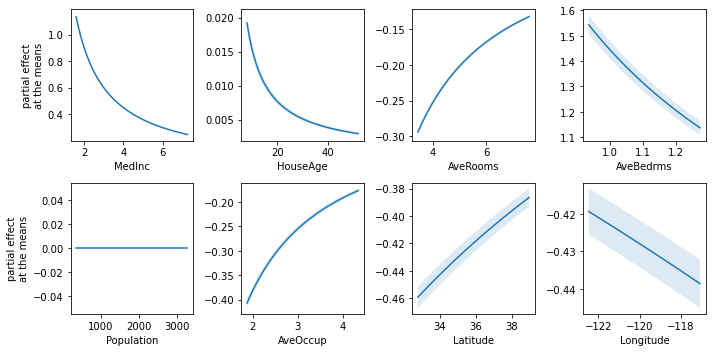

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

explainer.plot_partial_effects_at_means(
    X=X_test,
    features=range(8),
    ax=axs,
    num_points=100,
    share_y=False,
    show_err=True,
    show=False
)

plt.tight_layout()
plt.show()

Finally, we can also plot the mean relative importances of each feature by calculating the average Partial Effect for each interval when the output is discretized.

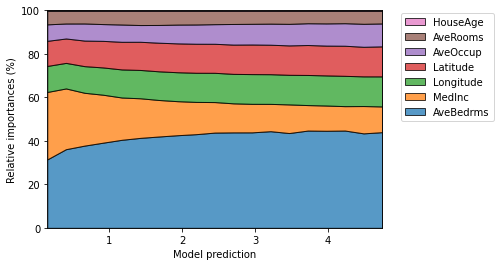

In [10]:
explainer.plot_normalized_partial_effects()